In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


url = "https://raw.githubusercontent.com/mikeizbicki/datasets/master/csv/uci/krkopt.data"

df = pd.read_csv(url, header=None)

df.columns = [
    "white_king_file", "white_king_rank",
    "white_rook_file", "white_rook_rank",
    "black_king_file", "black_king_rank",
    "result"
]

file_map = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}
for col in ["white_king_file", "white_rook_file", "black_king_file"]:
    df[col] = df[col].map(file_map)


result_map = {
    'draw': -1, 'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
    'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14,
    'fifteen': 15, 'sixteen': 16
}

if df['result'].dtype == 'object':
    df['result'] = df['result'].map(result_map)

df['dist_euclidean'] = np.sqrt(
    (df['white_king_file'] - df['black_king_file'])**2 + 
    (df['white_king_rank'] - df['black_king_rank'])**2
)

df['dist_manhattan'] = (
    abs(df['white_king_file'] - df['black_king_file']) + 
    abs(df['white_king_rank'] - df['black_king_rank'])
)

df['dist_chebyshev'] = np.maximum(
    abs(df['white_king_file'] - df['black_king_file']),
    abs(df['white_king_rank'] - df['black_king_rank'])
)

df['edge_dist_bk'] = df.apply(lambda row: min(
    row['black_king_file'] - 1, 8 - row['black_king_file'],
    row['black_king_rank'] - 1, 8 - row['black_king_rank']
), axis=1)








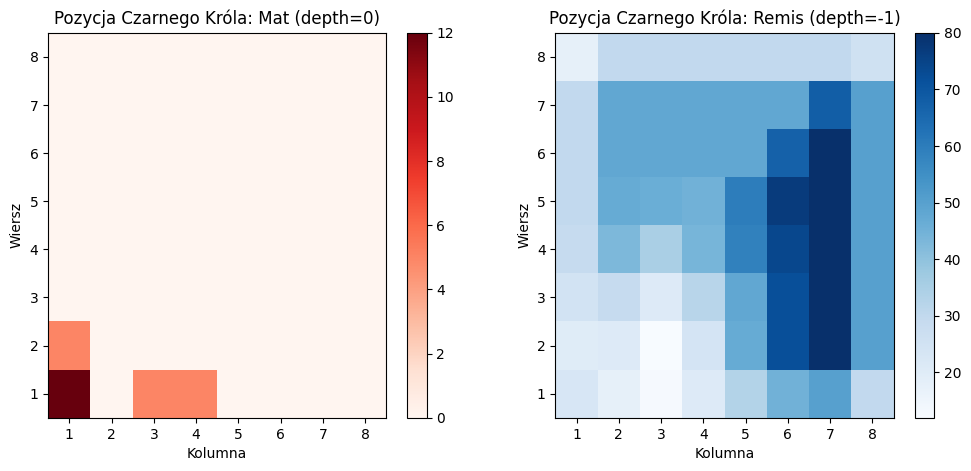

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
mate_data = df[df['result'] == 0]
plt.hist2d(mate_data['black_king_file'], mate_data['black_king_rank'], bins=[np.arange(0.5, 9.5), np.arange(0.5, 9.5)], cmap='Reds')
plt.title("Pozycja Czarnego Króla: Mat (depth=0)")
plt.xlabel("Kolumna")
plt.ylabel("Wiersz")
plt.colorbar()

plt.subplot(1, 2, 2)
draw_data = df[df['result'] == -1]
plt.hist2d(draw_data['black_king_file'], draw_data['black_king_rank'], bins=[np.arange(0.5, 9.5), np.arange(0.5, 9.5)], cmap='Blues')
plt.title("Pozycja Czarnego Króla: Remis (depth=-1)")
plt.xlabel("Kolumna")
plt.ylabel("Wiersz")
plt.colorbar()
plt.show()

### Pytanie 1: Gdzie znajduje się czarny król (Mat vs Remis)?

Na podstawie wizualizacji rozkładu pozycji czarnego króla:

* **Mat:** Czarny król znajduje się wtedy niemal wyłącznie w narożnikach planszy lub bezpośrednio przy jej krawędziach. Mapa ciepła wskazuje największą koncentrację (kolor ciemnoczerwony) w rogu planszy, co potwierdza regułę, że zamatowanie samotnego króla wymaga zepchnięcia go na skraj szachownicy.
* **Remis:** W sytuacjach zakończonych remisem, czarny król najczęściej okupuje centrum planszy. Utrzymywanie się w centrum zapewnia królowi większą liczbę dostępnych pól ucieczki, co utrudnia stronie atakującej skuteczne osaczenie.

In [12]:
clean_df = df[df['result'] != -1]
correlations = clean_df[['dist_euclidean', 'dist_manhattan', 'dist_chebyshev', 'result']].corr()['result']
print("\nKorelacja dystansu z liczbą ruchów do wygranej:")
print(correlations)


Korelacja dystansu z liczbą ruchów do wygranej:
dist_euclidean    0.290681
dist_manhattan    0.296696
dist_chebyshev    0.266009
result            1.000000
Name: result, dtype: float64


### Pytanie 2: Która metryka dystansu najlepiej szacuje liczbę ruchów?

Analiza korelacji liniowej zmiennych z liczbą ruchów do wygranej wskazuje na następującą kolejność przydatności metryk:

1.  Dystans Manhattan: korelacja 0.297
2.  Dystans Euklidesowy: korelacja 0.291
3.  Dystans Czebyszewa: korelacja 0.266

**Wniosek:** Najlepszym estymatorem spośród badanych miar jest metryka Manhattan.

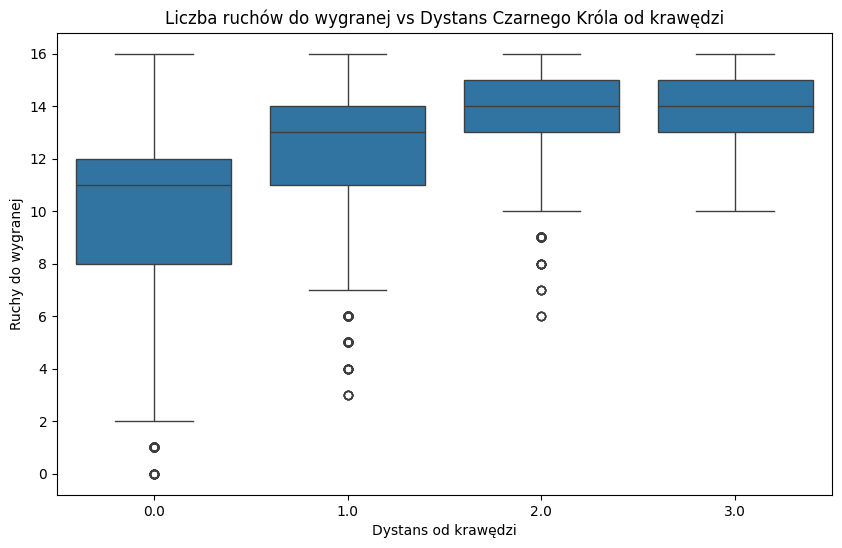

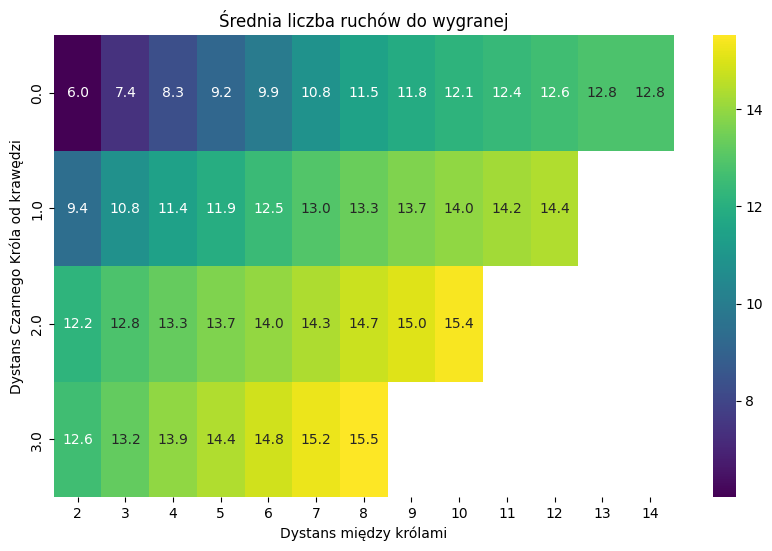

In [13]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='edge_dist_bk', y='result', data=clean_df)
plt.title("Liczba ruchów do wygranej vs Dystans Czarnego Króla od krawędzi")
plt.xlabel("Dystans od krawędzi")
plt.ylabel("Ruchy do wygranej")
plt.show()


pivot_table = clean_df.pivot_table(index='edge_dist_bk', columns='dist_manhattan', values='result', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="viridis")
plt.title("Średnia liczba ruchów do wygranej")
plt.xlabel("Dystans między królami")
plt.ylabel("Dystans Czarnego Króla od krawędzi")
plt.show()

### Pytanie 3: Przydatność odległości od krawędzi i analiza łączna

**1. Czy odległość od krawędzi jest przydatna?**
**Tak.** Wykresy pudełkowe wykazują wyraźną zależność: im bliżej krawędzi znajduje się czarny król, tym średnio mniej ruchów potrzeba do wygranej. Dla króla na bandzie (`0`) mediana wynosi ok. 11 ruchów, podczas gdy dla króla w centrum wzrasta do ok. 14 ruchów.

**2. Czy łączenie cech pomaga?**
Zdecydowanie tak. Macierz średniej liczby ruchów pokazuje, że sama informacja o dystansie między królami jest niewystarczająca bez kontekstu pozycji na planszy.

Uzupełnienie informacji o odległość od krawędzi pozwala precyzyjnie rozróżnić sytuacje łatwe od trudnych, które przy użyciu tylko jednej zmiennej wyglądałyby podobnie.